
# Compute full spectrum source space connectivity between labels

The connectivity is computed between 4 labels across the spectrum
between 7.5 Hz and 40 Hz.


Automatically created module for IPython interactive environment
Reading inverse operator decomposition from /home/wanglab/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information 

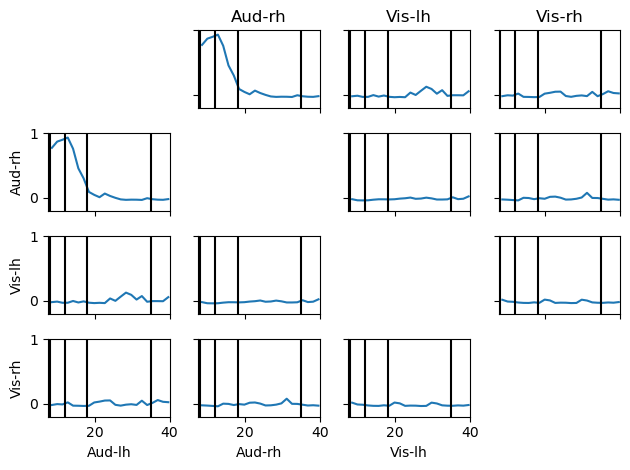

In [1]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#
# License: BSD (3-clause)

import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne_connectivity import spectral_connectivity_epochs

print(__doc__)

data_path = sample.data_path()
subjects_dir = data_path / "subjects"
fname_inv = data_path / "MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"
fname_raw = data_path / "MEG/sample/sample_audvis_filt-0-40_raw.fif"
fname_event = data_path / "MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"

# Load data
inverse_operator = read_inverse_operator(fname_inv)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Add a bad channel
raw.info["bads"] += ["MEG 2443"]

# Pick MEG channels
picks = mne.pick_types(
    raw.info, meg=True, eeg=False, stim=False, eog=True, exclude="bads"
)

# Define epochs for left-auditory condition
event_id, tmin, tmax = 1, -0.2, 0.5
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6),
)

# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list.
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr**2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(
    epochs, inverse_operator, lambda2, method, pick_ori="normal", return_generator=True
)

# Read some labels
names = ["Aud-lh", "Aud-rh", "Vis-lh", "Vis-rh"]
labels = [
    mne.read_label(data_path / f"MEG/sample/labels/{name}.label") for name in names
]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode="mean_flip", return_generator=True
)

fmin, fmax = 7.5, 40.0
sfreq = raw.info["sfreq"]  # the sampling frequency

con = spectral_connectivity_epochs(
    label_ts,
    method="wpli2_debiased",
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    mt_adaptive=True,
    n_jobs=1,
)
freqs = con.freqs

n_rows, n_cols = con.get_data(output="dense").shape[:2]
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
for i in range(n_rows):
    for j in range(i + 1):
        if i == j:
            axes[i, j].set_axis_off()
            continue

        axes[i, j].plot(freqs, con.get_data(output="dense")[i, j, :])
        axes[j, i].plot(freqs, con.get_data(output="dense")[i, j, :])

        if j == 0:
            axes[i, j].set_ylabel(names[i])
            axes[0, i].set_title(names[i])
        if i == (n_rows - 1):
            axes[i, j].set_xlabel(names[j])
        axes[i, j].set(xlim=[fmin, fmax], ylim=[-0.2, 1])
        axes[j, i].set(xlim=[fmin, fmax], ylim=[-0.2, 1])

        # Show band limits
        for f in [8, 12, 18, 35]:
            axes[i, j].axvline(f, color="k")
            axes[j, i].axvline(f, color="k")
plt.tight_layout()
plt.show()